# NYU Talk (Ocean Transport and Eddy Energy CPT)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Latex

$$K_e = K_\rho \frac{(\partial_z C_e)^2}{|\nabla_n C_m|^2}$$

$$\langle u_t C_t \cdot \nabla C_e \rangle = K_\rho(\partial_z C_e)^2$$

$$\langle u_t C_t \cdot \nabla_n C_m \rangle = K_\rho(\partial_z C_m)^2$$

$$(\partial_z C_e)^2 / [(\partial_z C_e)^2 + (\partial_z C_m)^2]$$

$[1]$ $\langle u_e C_e \rangle \cdot \nabla_n C_m \approx K_e|\nabla_n C_m|^2$

$[2]$ $\langle u_t C_t \cdot \nabla C_e \rangle \approx K_\rho(\partial_z C_e)^2$

$[3]$ $\langle u_t C_t \rangle \cdot \nabla C_m \approx K_\rho(\partial_z C_m)^2$

$[4]$ $\langle \chi \rangle = \kappa_C|\nabla C_t |^2$

$C = C_m + C_e + C_t$

where
- $C_m$: mean tracer profile
- $C_e$: eddy (mesoscale) tracer profile
- $C_t$: turbulent (microscale) tracer profile

$\langle u_e \theta_e \rangle = K_e |\nabla_n \theta_m |$

$K_e *|\nabla_n \theta_m | *\rho* c_p$

In [180]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')
ct_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_3.nc')
ct_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_e_3.nc')

Text(0.5, 1.0, 'Example Temperature Profiles')

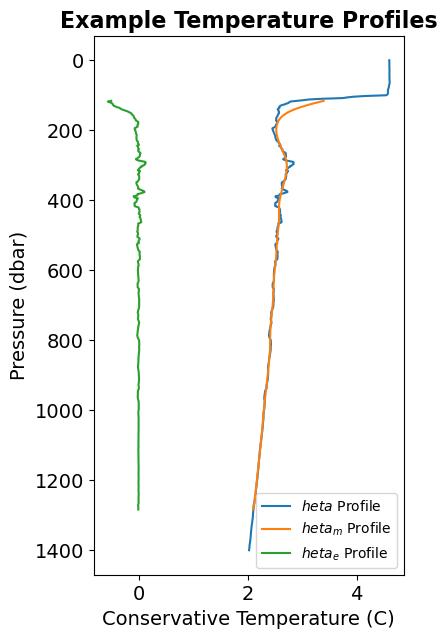

In [182]:
plt.figure(figsize=(4,7))
ds.CT.isel(N_PROF=100000).plot(y='PRES_INTERPOLATED',label='$\theta$ Profile')
ct_m.isel(N_PROF=100000).plot(y='PRES_INTERPOLATED',label='$\theta_m$ Profile')
ct_e.isel(N_PROF=100000).plot(y='PRES_INTERPOLATED',label='$\theta_e$ Profile')
plt.gca().invert_yaxis()
plt.xlabel('Conservative Temperature (C)')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.title('Example Temperature Profiles')

In [39]:
ds_gridded = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_gridded_3_z.nc')
ds_gridded_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_rho_binned_high_res.nc').rename({'lon_c':'lon','lat_c':'lat'})

In [4]:
term2_ds_CT = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2_CT = term2_ds_CT.ct_e_z2_filt.rename('term2')
term3_CT = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()

In [7]:
term2_ds_SA = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2_sa.nc').load()
term2_SA = term2_ds_SA.sa_e_z2_filt.rename('term2')
term3_SA = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/term3_sa.nc').rename('term3').load()

In [5]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx

In [6]:
K_e_CT = K_rho*term2_CT/term3_CT

In [8]:
K_e_SA = K_rho*(term2_SA/term3_SA**2)

In [89]:
density = 27.2
title= 'Pressure'
units = "dbar"
ds = ds_gridded_rho.PRES.copy(data=ds_gridded_rho.PRES.data)
ds.name = title; ds.attrs["units"] = units
cmap, norm, levels = cmo.speed, colors.Normalize(vmin=0, vmax=2000), np.arange(0, 2001, 250)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, levels=levels)
ax.set_title(f"{title} on density surface: {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/1661665281.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title} on density surface: {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/1408466855.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = '$\mathbf{{K_e}}$ from Conservative Temperature'
/tmp/ipykernel_7613/1408466855.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


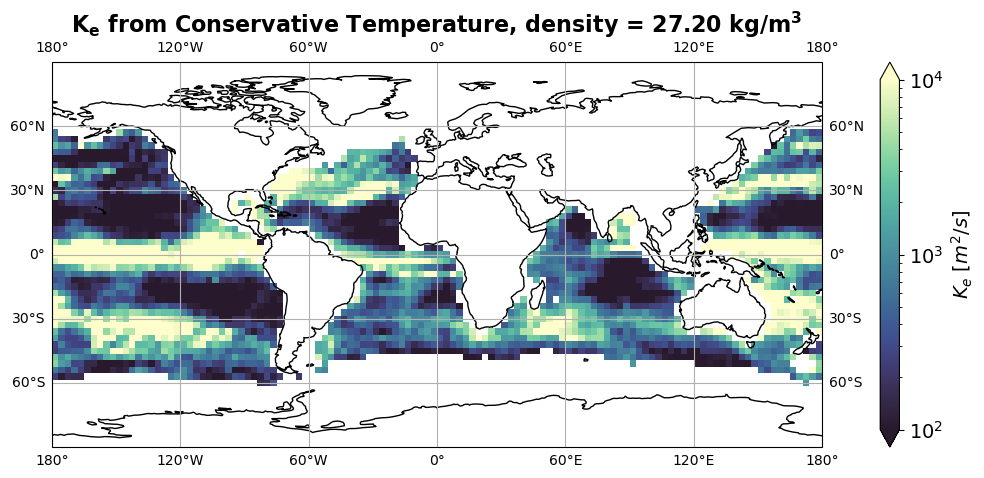

In [90]:
density = 27.2
title = '$\mathbf{{K_e}}$ from Conservative Temperature'
name = '$K_e$'
units = '$m^2/s$'
ds = K_e_CT.copy(data=K_e_CT)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=1e2, vmax=1e4)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

In [91]:
density = 27.2
title = '$\mathbf{{K_e}}$ from Absolute Salinity'
name = '$K_e$'
units = '$m^2/s$'
ds = K_e_SA.copy(data=K_e_SA)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=1e2, vmax=1e4)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/3368738509.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = '$\mathbf{{K_e}}$ from Absolute Salinity'
/tmp/ipykernel_7613/3368738509.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


In [83]:
ct_meso_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_meso_VPR.nc')
ct_micro_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_micro_VPR.nc')
ct2_frac_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct2_frac.nc')

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/2341952815.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


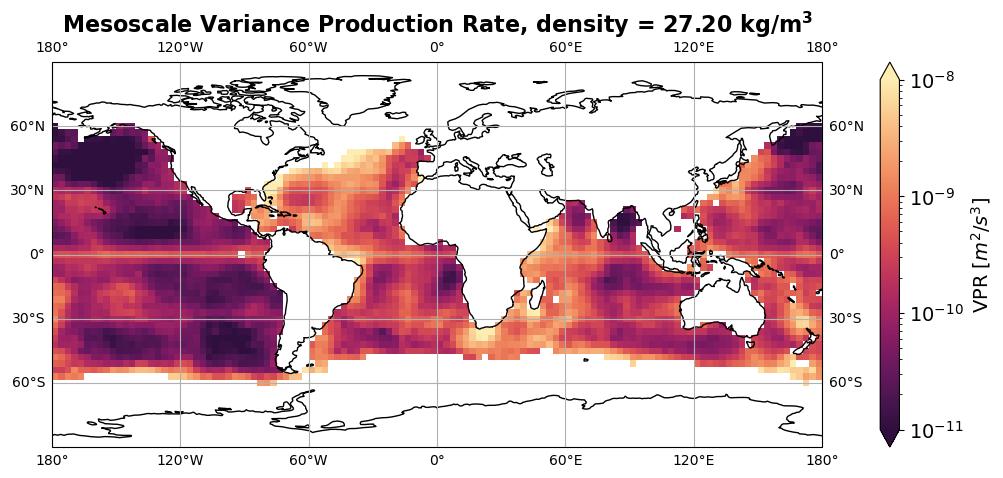

In [94]:
density = 27.2
title = 'Mesoscale Variance Production Rate'
name = 'VPR'
units = '$m^2/s^3$'
ds = ct_meso_VPR.copy(data=ct_meso_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

In [93]:
density = 27.2
title = 'Microscale Variance Production Rate'
name = 'Micro VPR'
units = '$m^2/s^3$'
ds = ct_micro_VPR.copy(data=ct_micro_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/4050753163.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/2013856225.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


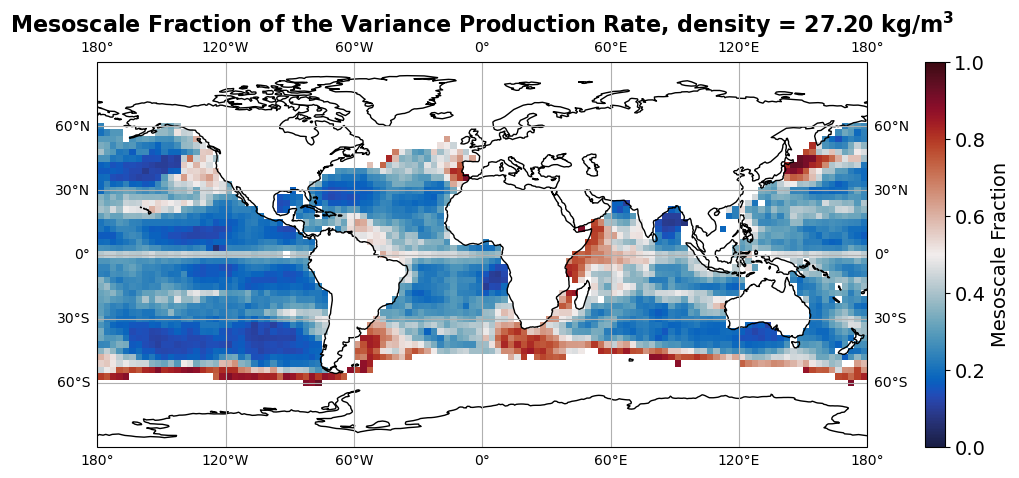

In [92]:
density = 27.2
title = 'Mesoscale Fraction of the Variance Production Rate'
name = 'Mesoscale Fraction'
ds = ct2_frac_VPR.copy(data=ct2_frac_VPR)
ds.name = name
cmap, norm = cmo.balance, colors.Normalize(vmin=0, vmax=1)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

In [95]:
dCT_dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dx.nc')
dCT_dy = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dy.nc')

In [97]:
F_CT_x = -K_e_CT*dCT_dx
F_CT_y = -K_e_CT*dCT_dy
F_CT_xy = -K_e_CT*np.sqrt(dCT_dx**2 + dCT_dy**2)

<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/2198285179.py:30: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


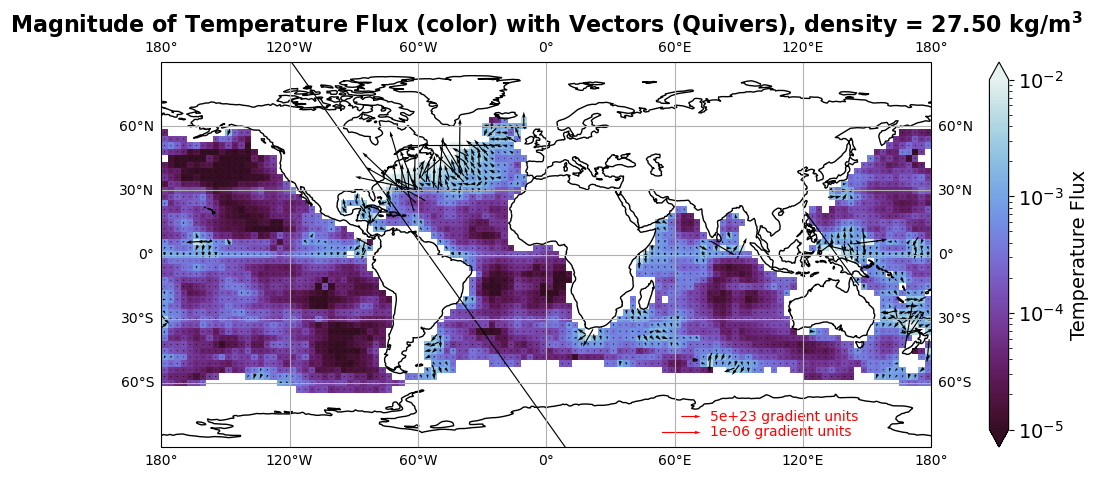

In [115]:
density = 27.5
title = 'Magnitude of Temperature Flux (color) with Vectors (Quivers)'
name = 'Temperature Flux'
units = '$C m/s$'
ds = -F_CT_xy.copy(data=F_CT_xy)
ds.name = name
cmap, norm = cmo.dense_r, colors.LogNorm(vmin=1e-5, vmax=1e-2)

# Choose a density slice—here using index, but you could use `.sel(density=...)` too
u = F_CT_x.sel(density=density, method='nearest')
v = F_CT_y.sel(density=density, method='nearest')

# Create meshgrid from coordinates for plotting
X, Y = u['lon'], u['lat']
XX, YY = np.meshgrid(X, Y, indexing='ij')  # match xarray's dimension order

# Transpose u and v to match meshgrid shape (lon x lat)
U = u.transpose('lon', 'lat').values
V = v.transpose('lon', 'lat').values

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
q = ax.quiver(XX, YY, U, V, scale=2e-1, pivot='middle', width=0.0015)
ax.quiverkey(q, X=0.7, Y=0.08, U=5e-3, label=f'{5e-3:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
ax.quiverkey(q, X=0.7, Y=0.04, U=1e-2, label=f'{1e-6:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

In [121]:
density = 27.5
title = 'Magnitude and Direction of Temperature Flux'
name = 'Temperature Flux'
units = '$C m/s$'
ds = -F_CT_xy.copy(data=F_CT_xy)
ds.name = name
cmap, norm = cmo.dense_r, colors.LogNorm(vmin=1e-5, vmax=1e-2)

# Choose a density slice—here using index, but you could use `.sel(density=...)` too
u = F_CT_x.sel(density=density, method='nearest')
v = F_CT_y.sel(density=density, method='nearest')

# Create meshgrid from coordinates for plotting
X, Y = u['lon'], u['lat']
XX, YY = np.meshgrid(X, Y, indexing='ij')  # match xarray's dimension order

# Transpose u and v to match meshgrid shape (lon x lat)
U = u.transpose('lon', 'lat').values
V = v.transpose('lon', 'lat').values

# Mask out extreme vectors
mag = np.sqrt(U**2 + V**2)
threshold = 1e-1  # adjust as needed
mask = mag < threshold
U = np.where(mask, U, np.nan)
V = np.where(mask, V, np.nan)

fig = plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(
    x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm
)
q = ax.quiver(XX, YY, U, V, scale=3e-1, pivot='middle', width=0.0015)
ax.quiverkey(q, X=0.7, Y=0.08, U=5e-3, label=f'{5e23:.0e} gradient units', labelpos='E', color='r', labelcolor='r')
ax.quiverkey(q, X=0.7, Y=0.04, U=1e-2, label=f'{1e-6:.0e} gradient units', labelpos='E', color='r', labelcolor='r')
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$")

<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/3864552137.py:39: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$")


Text(0.5, 1.0, 'Magnitude and Direction of Temperature Flux, density = 27.50 $\\mathbf{kg/m^3}$')

In [141]:
PF = xr.open_dataarray('/swot/SUM05/amf2288/acc_fronts/CTOH_PolarFront_weekly_1993_2023.nc')
SAF = xr.open_dataarray('/swot/SUM05/amf2288/acc_fronts/CTOH_SubantarcticFront_weekly_1993_2023.nc')

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/4221299723.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer

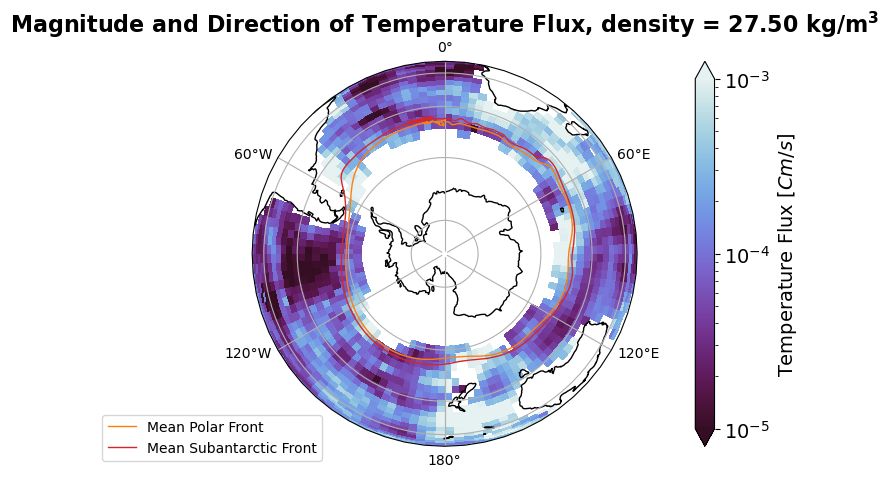

In [151]:
density = 27.50
title = 'Magnitude and Direction of Temperature Flux'
name = 'Temperature Flux'
units = '$C m/s$'
ds = -F_CT_xy.copy(data=F_CT_xy)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.dense_r, colors.LogNorm(vmin=1e-5, vmax=1e-3)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=-90))
ax.coastlines()
ax.gridlines(draw_labels=True)
#ax.set_extent([-180,180,-90,-30], crs=ccrs.PlateCarree())
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.plot(PF.longitude.mean('time'), PF.mean('time'), color='tab:orange', linewidth=1, transform=ccrs.PlateCarree(), label='Mean Polar Front')
ax.plot(SAF.longitude.mean('time'), SAF.mean('time'), color='tab:red', linewidth=1, transform=ccrs.PlateCarree(), label='Mean Subantarctic Front')
ax.legend(bbox_to_anchor=(0.2,0.1))
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

In [155]:
# Drop NaNs from PF and get valid indices
valid = ~np.isnan(PF.values)
pf_lon_vals = PF.longitude.values[valid]
pf_lat_vals = PF.values[valid]

# Match PF longitudes to nearest heat_flux lon indices
hf_lon_vals = F_CT_xy.lon.values
lon_idx = np.abs(hf_lon_vals[:, None] - pf_lon_vals).argmin(axis=0)

# Match PF latitudes to nearest heat_flux lat indices
hf_lat_vals = F_CT_xy.lat.values
lat_idx = np.abs(hf_lat_vals[:, None] - pf_lat_vals).argmin(axis=0)

# Extract heat flux along the front
# This will be a new DataArray with shape (density, len(pf_lon_vals))
hf_front = F_CT_xy.isel(lon=xr.DataArray(lon_idx, dims='front'),
                          lat=xr.DataArray(lat_idx, dims='front'))

hf_front.coords['longitude'] = ('front', pf_lon_vals)
hf_front.coords['latitude'] = ('front', pf_lat_vals)

In [156]:
hf_front

<xarray.DataArray (density: 3200, front: 4102107)> Size: 105GB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon        (front) float64 33MB 1.5 1.5 1.5 1.5 ... 178.5 178.5 178.5 178.5
    lat        (front) float64 33MB -45.0 -45.0 -45.0 ... -48.0 -48.0 -48.0
  * density    (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
    longitude  (front) float32 16MB 0.125 0.375 0.625 ... 359.5 359.6 359.9
    latitude   (front) float32 16MB -46.1 -46.04 -45.99 ... -46.88 -46.93 -46.99
Dimensions without coordinates: front